In [4]:
%reload_ext autoreload
%autoreload 2

import subtle.subtle_loss as suloss
from subtle.dnn.helpers import load_model, load_data_loader
from subtle.dnn.generators import GeneratorUNet2D
from subtle.dnn.adversaries import AdversaryPatch2D, AdversaryDense2D
from subtle.dnn.helpers import gan_model
from subtle.data_loaders import SliceLoader
import os
from subtle.utils.io import load_file
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from subtle.subtle_preprocess import zero_pad

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (20, 12)

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)

<Figure size 432x288 with 0 Axes>

In [ ]:
train_cases = ['NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'NO6', 'NO7', 'NO8', 'NO9', 'NO10']
test_cases = ['NO11', 'NO12', 'NO13']
base_path = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data'
save_path = '/home/srivathsa/projects/studies/gad/tiantan/train/logs/data/MR'

train = False
all_cases = train_cases if train else test_cases
subfolder = 'train' if train else 'test'

for cname in all_cases:
    data_h5 = zero_pad(load_file('{}/{}.h5'.format(base_path, cname)), 256)
    # data_h5 = data_h5[50:150]
    for slice_idx in tqdm(range(data_h5.shape[0]), total=data_h5.shape[0]):
        imgA = np.array([data_h5[slice_idx, 0]]).transpose(1, 2, 0)
        imgB = np.array([data_h5[slice_idx, 2]]).transpose(1, 2, 0)
        
        np.save('{}/{}A/{}_{}.npy'.format(save_path, subfolder, cname, slice_idx), imgA)
        np.save('{}/{}B/{}_{}.npy'.format(save_path, subfolder, cname, slice_idx), imgB)

In [ ]:
pred = np.load('/home/srivathsa/projects/studies/gad/tiantan/train/logs/cgan_images/20200114-153552/Btest/epoch4_sample1.npy')

show_img(pred)

In [ ]:
import numpy as np

pred = np.load('/home/srivathsa/projects/studies/gad/tiantan/train/logs/pixpred/pred_10.npy')

show_img(pred[7, ..., 1])

In [ ]:
data, data_mask = load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO33.h5', 
                            file_type='h5', params={'h5_key': 'all'})

(100, 3)


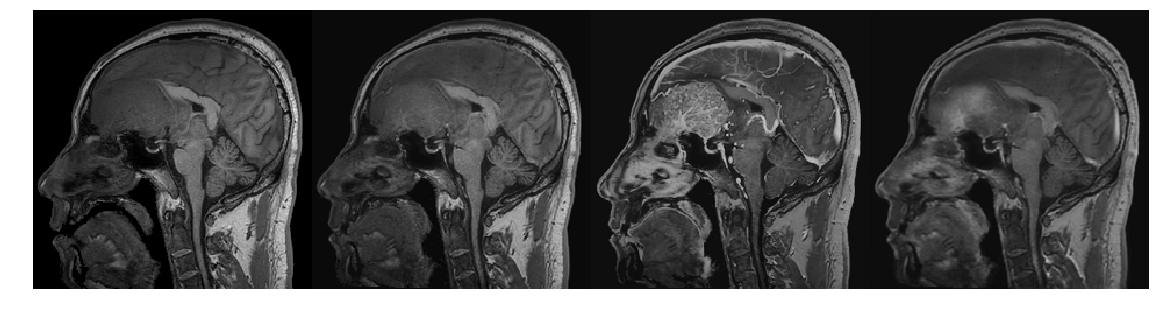

In [5]:
import numpy as np

gan_progress = np.load('/home/srivathsa/projects/studies/gad/tiantan/train/logs/gan_progress.npy', allow_pickle=True)
print(gan_progress.shape)
img = gan_progress[2][0]
show_img(img)

In [ ]:
Y_n = np.load('/home/srivathsa/projects/studies/gad/tiantan/train/logs/Y_n.npy', allow_pickle=True)
g_n = np.load('/home/srivathsa/projects/studies/gad/tiantan/train/logs/g_n.npy')

show_img(g_n[0, ..., 0])

In [ ]:
loss_function = suloss.mixed_loss(l1_lambda=0.5, ssim_lambda=0.5)
metrics_monitor = [suloss.l1_loss, suloss.ssim_loss, suloss.mse_loss]

model_kwargs = {
    'num_channel_output': 1,
    'loss_function': loss_function,
    'metrics_monitor': metrics_monitor,
    'lr_init': 0.001,
    'verbose': 1,
    'img_rows': 240,
    'img_cols': 240,
    'num_channel_input': 14
}

model = GeneratorUNet2D(**model_kwargs)

In [ ]:
gen = model.model
d = AdversaryDense2D(
    img_rows=240, img_cols=240, compile_model=True
)
disc = d.model

In [ ]:
gan = gan_model(gen, disc, (240, 240, 14))

gan.load_weights('/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/tiantan_gan_novgg.checkpoint')

In [ ]:
fpath_h5 = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO31.h5'

pred_gen = SliceLoader(
    data_list=[fpath_h5],
    batch_size=8,
    shuffle=False,
    verbose=1,
    residual_mode=False,
    slices_per_input=7,
    slice_axis=[0],
    file_ext='h5'
)

In [ ]:
y_pred = gen.predict_generator(pred_gen)

In [ ]:
show_img(y_pred[96, ..., 0])